In [1]:
%matplotlib inline
#%matplotlib notebook

import numpy as np

sys_import = False

if sys_import:
    try:
        from rb_cqed import Atom87Rb
        print("Imported rb_cqed from system.")
    except:
        sys_import = False
if not sys_import:
    import os
    i=0
    while i<5:
        try:
            from rb_cqed import Atom87Rb, Cavity, CavityCoupling, LaserCoupling, ExperimentalRunner
            print('Set cwd to ', os.getcwd()) 
            print("rb_cqed not found on system, importing from file.")
            break
        except Exception as e:
            os.chdir('../')
            i+=1

i = np.complex(0,1)

Set cwd to  /Users/tombarrett/PycharmProjects/Atomic and Laser Physics/rb-cqed
rb_cqed not found on system, importing from file.


# Section 3 - Full $^{87}$Rb atom

### 3.1 Inspecting the Atom87Rb class
<a id='sec_3_1'></a>

In [2]:
atom = Atom87Rb()

In [3]:
print("The ground states of the Atom87Rb are:", list(atom.g_states.keys()))
print("The excited states of the Atom87Rb are:", list(atom.x_states.keys()))

The ground states of the Atom87Rb are: ['g1M', 'g1', 'g1P', 'g2MM', 'g2M', 'g2', 'g2P', 'g2PP']
The excited states of the Atom87Rb are: ['x0', 'x1M', 'x1', 'x1P', 'x2MM', 'x2M', 'x2', 'x2P', 'x2PP', 'x3MMM', 'x3MM', 'x3M', 'x3', 'x3P', 'x3PP', 'x3PPP']


In [4]:
print("The dictionary of tranistion strengths from level x1 is:")
print(atom.transition_strengths['x1'])

print("\nThe sum of the tranisition coeffs ** 2, for all tranistions from a give excited level is:")
for x in atom.x_states.keys():
    sum_of_strengths = np.sum([x**2 for x in atom.transition_strengths[x].values()])
    print("\t{} : {}".format(x,np.round(sum_of_strengths,3)))

The dictionary of tranistion strengths from level x1 is:
{'g1M': 0.45643546458763845, 'g1': 0.0, 'g1P': -0.45643546458763845, 'g2MM': 0, 'g2M': 0.15811388300841897, 'g2': 0.18257418583505536, 'g2P': 0.15811388300841897, 'g2PP': 0}

The sum of the tranisition coeffs ** 2, for all tranistions from a give excited level is:
	x0 : 0.5
	x1M : 0.5
	x1 : 0.5
	x1P : 0.5
	x2MM : 0.5
	x2M : 0.5
	x2 : 0.5
	x2P : 0.5
	x2PP : 0.5
	x3MMM : 0.5
	x3MM : 0.5
	x3M : 0.5
	x3 : 0.5
	x3P : 0.5
	x3PP : 0.5
	x3PPP : 0.5


### 3.x Basic calculations
<a id='sec_3_x'></a>

##### Rabi Oscillations

For configured state x0 it is 0.4082482904638631.  Check the parameter file or carry on if you know what
you are doing.
A pre-compiled Hamiltonian is suitable to run this experiment.
Running simulation with 501 timesteps...finished in 0.274 seconds


(<Figure size 864x198 with 2 Axes>, <Figure size 864x198 with 1 Axes>)

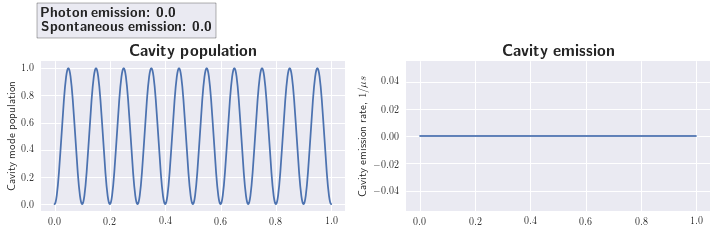

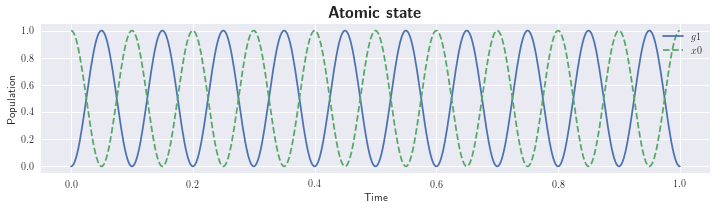

In [15]:
atom = Atom87Rb(configured_states=['x0','g1'], x_zero_energy_state='x0',gamma=0)
cav = Cavity(g = 5 * 2.*np.pi / atom.transition_strengths['x0']['g1'],
             kappa = 0. * 2.*np.pi)

cavity_coupling = CavityCoupling(g0=cav.g,
                                 g='g1', x='x0',
                                 deltaC = 0 * 2*np.pi,
                                 deltaM=[0],
                                 couple_off_resonance=False)

runner = ExperimentalRunner(atom=atom,
                            cavity=cav,
                            laser_couplings=[],
                            cavity_couplings=cavity_coupling,
                            verbose=True)

psi0 = runner.ket('x0',0)
t_length = 1
n_steps = 501

results = runner.run(psi0, t_length, n_steps)

results.plot(['x0','g1'])

Todo:

- Ensure a sensible default for x_zero_energy_state is chosen.
- Add options for a sink state to be included.

##### Rabi Oscillations

For configured state x0 it is 0.8164965809277261.  Check the parameter file or carry on if you know what
you are doing.
No suitable pre-compiled Hamiltonian found.  Generating and compiling Cython file...
	additional setup required:
		preparing .pyx file with rhs_prepare(...)...
		customising .pyx file...
		compiling Cython function with rhs_compile...done.
	The pyx file was deleted after compilation.  Complete in 4.039 seconds.
Running simulation with 501 timesteps...finished in 0.095 seconds


(<Figure size 864x198 with 2 Axes>, <Figure size 864x198 with 1 Axes>)

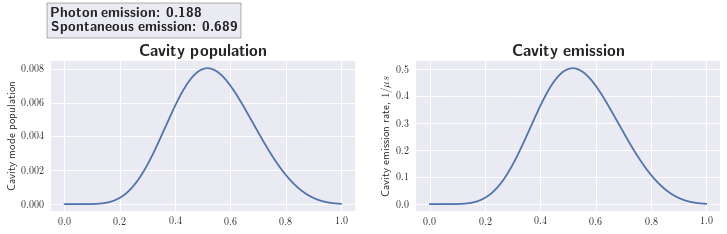

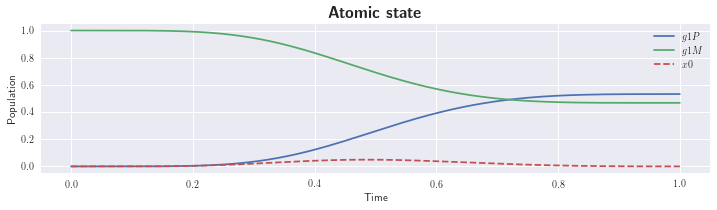

In [22]:
atom = Atom87Rb(configured_states=['x0','g1M', 'g1P'], x_zero_energy_state='x0', gamma=3 * 2.*np.pi)
cav = Cavity(g = 5 * 2.*np.pi,
             kappa = 5. * 2.*np.pi)

pulse_c_str = \
'''
@cython.cdivision(True)
@cython.boundscheck(False)
@cython.wraparound(False)
cdef double complex pulse_c(float t, float t_start, float t_end, float omega):
    if t_start<=t<=t_end: return sin(omega*(t-t_start))**2
    else: return 0
'''

length_pulse = 1
w_pulse = np.pi / length_pulse

laser_coupling = LaserCoupling(omega0=5 * 2*np.pi,
                               g='g1M', x='x0',
                               deltaL = 0 * 2*np.pi,
                               deltaM=[1,-1],
                               pulse_shape='pulse_c(t, 0, length_pulse, w_pulse)',
                               args_ham={"length_pulse":length_pulse,
                                         "w_pulse":w_pulse},
                               setup_pyx=[''],
                               add_pyx=[pulse_c_str],
                               couple_off_resonance=False)

cavity_coupling = CavityCoupling(g0=cav.g,
                                 g='g1P', x='x0',
                                 deltaC = 0 * 2*np.pi,
                                 deltaM=[1,-1],
                                 couple_off_resonance=False)

runner = ExperimentalRunner(atom,cav,laser_coupling,cavity_coupling,
                            verbose=True)

psi0 = runner.ket('g1M',0)
t_length = 1
n_steps = 501

results = runner.run(psi0, t_length, n_steps)

results.plot()